In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as py
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn import preprocessing
from geopy.geocoders import Nominatim
import folium
import unicodedata

![alt text](logo_nestle.jpg "Title")

<h2>Seção Inicial: Leitura, Seleção e Formatação Inicial dos dados</h2>

<p>Nessa seção, buscamos entender o contexto geral e as raízes do problema proposto. Para isso, definimos um recorte e realizamos o refinamento das informações disponibilizadas pela Nestlé e pela Vem de Bolo, por meio do tratamento dos dados considerados relevantes, porém ainda sem uma preocupação analítica. Para isso, significativo julgamento foi utilizado, considerando fatores como densidade e completude dos dados, significância estatística, avaliação crítica das operações atuais e pertinência dos dados perante a decisão a ser tomada sobre a expansão geográfica da plataforma.</p>

<h3>As Consumidoras</h3>
<p>Optamos por utilizar apenas os dados das consumidoras ativas, ou seja, daquelas que efetivamente estão consumindo os produtos da plataforma, pois entendemos que assim seria possível compreender melhor os padrões de consumo e preferências dessas consumidoras. A respeito, identificamos 32 consumidoras com perfil <em>heavy users</em>, ou seja, com mais de 10 compras na plataforma, e outras 2.717 consumidoras que já realizaram até 10 transações na plataforma. Foram identificadas ainda 4.256 consumidoras cadastradas que nunca utilizaram a plataforma, as quais foram desconsideradas para os fins da análise em tela.</p>
<p>Com relação aos dados das consumidoras, entendemos que os campos <em>'nome_completo'</em>, <em>'id_fornecedor'</em>, <em>'aceita_thrid_party_mkt'</em> e <em>'aceita_mkt'</em> possuem baixo poder informacional no contexto da análise, por se tratarem de <em>private keys</em> e/ou por não terem conteúdo informacional que auxilie a decisão acerca da expansão geográfica da plataforma. Por isso, os referidos dados não foram utilizados.</p>
<ul>
<li><h4>Tabela de consumidoras dos produtos da plataforma (tb_users)</h4></li>
</ul>

In [2]:
df_users = pd.read_csv('tb_users.csv', sep = ";")

In [3]:
#checando se há consumidoras duplicadas
df_users.id_usuario.duplicated().any()

False

In [4]:
#separando as consumidoras entre: as que nunca utilizaram a plataforma,
#as recorrentes (até 10 compras) e as heavy users (mais de 10 compras)

filtro_consumidoras = df_users.qtde_total_compra
consumidoras_por_categoria = pd.cut(filtro_consumidoras.values,
                                    bins=[-1,0,10,filtro_consumidoras.max()],
                                    labels=['0','1-10','11-43'],
                                    include_lowest=True)
consumidoras_por_categoria.value_counts()

0        4256
1-10     2717
11-43      32
dtype: int64

In [5]:
df_users.query('qtde_total_compra != 0.0', inplace=True)
df_users.drop(labels=['nome_completo', 'id_fornecedor', 'data_ultima_compra',
                      'aceita_thrid_party_mkt', 'aceita_mkt'], axis=1, inplace=True)
df_users.head()

id_usuario  qtde_total_compra  gasto_total  \
0   5faafcaf19bbc50021fe3f07                6.0       408.92   
7   5fabf0a94d36ff0021e3b8ca                1.0        51.37   
8   5fabf8144d36ff0021e3c900                1.0        70.00   
9   5fac04634d36ff0021e3e666                2.0       241.55   
12  5fac1b0d4d36ff0021e41779                2.0       189.83   

    ultima_qtde_compra  ticket_medio  
0                78.40         68.15  
7                51.37         51.37  
8                70.00         70.00  
9                98.33        120.78  
12               79.88         94.92

<p>Ainda com relação as consumidoras, a tabela de cupons de descontos traz informações acerca da efetividade e da abrangência dessas iniciativas. Os campos <em>'novos_clientes_adquiridos'</em> e <em>'qtde_uso'</em> foram considerados relevantes, pois apontam métodos a serem utilizados pela plataforma em sua estratégia de expansão. Os demais dados da tabela foram desconsiderados.</p>
<ul>
<li><h4>Tabela de cupons promocionais (tb_coupons)</h4></li>
</ul>

In [6]:
df_coupons = pd.read_csv('tb_coupons.csv', sep = ";")

In [7]:
df_coupons = df_coupons[['novos_clientes_adquiridos', 'qtde_uso']]
df_coupons.dropna(subset=['novos_clientes_adquiridos'], inplace=True)
df_coupons.head()

novos_clientes_adquiridos  qtde_uso
0                       34.0      40.0
2                        9.0      12.0
4                       56.0      83.0
5                      117.0     148.0
7                       89.0     129.0

<h3>As Vendedoras</h3>
<p>Partindo para os fornecedores, entendemos que a lista dos fornecedores cadastrados na plataforma consiste em uma lista de fornecedores <strong>legada</strong>, uma vez que existem cerca de 87 mil fornecedores cadastrados, localizados por todo o país, o que seria inverossímil considerando que a Vem de Bolo opera apenas na região metropolitana de São Paulo e consiste em uma iniciativa relativamente recente. Portanto, o poder informacional da referida lista no contexto da análise é considerado baixo.</p>
<ul>
<li><h4>Tabela de endereços dos fornecedores cadastrados na plataforma (tb_addresses)</h4></li>
</ul>

In [8]:
df_addresses = pd.read_csv('tb_addresses.csv', sep = ";")
df_addresses.uf.unique()

array(['AC', 'AL', 'AM', 'AP', 'BA', 'SP', 'CE', 'DF', 'ES', 'GO', 'MA',
       'RJ', 'MG', 'PA', 'MS', 'MT', 'PB', 'PE', 'PI', 'PR', 'Paraná',
       'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'TO'], dtype=object)

<p>Na segunda tabela de fornecedores (os <em>'vendors'</em>), são disponibilizados dados de 403 fornecedores (em oposição aos 87 mil da primeira tabela), de modo que entendemos tratar-se das vendedoras efetivamente cadastradas na plataforma Vem de Bolo. Na tabela, os dados são ampliados para além dos endereços, passando a informar acerca de aspectos operacionais dessas vendedoras, tais como produtos disponíveis, preços praticados, horários de funcionamento, dentre outros. Contudo, esses dados operacionais foram fornecidos todos zerados, de modo que não são úteis para análise.</p>
<p>Por fim, cabe mencionar que dois terços das 403 vendedoras cadastradas não estavam aprovadas para operar na data de extração dos dados, de modo que optamos por trabalhar apenas com as vendedoras em operação.</p>
<ul>
<li><h4>Tabela de fornecedores cadastrados na plataforma (tb_vendors)</h4></li>
</ul>

In [9]:
df_vendors = pd.read_csv('tb_vendors.csv', sep = ";")

In [10]:
df_vendors.e_aprovado.value_counts(normalize=True)

False    0.674938
True     0.325062
Name: e_aprovado, dtype: float64

In [11]:
display(df_vendors.preco_medio.value_counts())
display(df_vendors.qtde_produtos.value_counts())
display(df_vendors.avaliacao_media.value_counts())

0    403
Name: preco_medio, dtype: int64

0    403
Name: qtde_produtos, dtype: int64

0    403
Name: avaliacao_media, dtype: int64

In [12]:
df_vendors.query('e_aprovado == True', inplace=True)
df_vendors.drop(labels=['qtde_produtos', 'preco_medio', 'avaliacao_media'], axis=1, inplace=True)

<h3>Os Produtos</h3>
<p>Por fim, consideramos as informações sobre produtos de alta relevância para análise, pois a partir da descrição de quais são os produtos de maior apelo junto ao público, podemos extrapolar o perfil de consumo com maior aderência em outras regiões do Brasil, gerando possíveis <em>insights</em> acerca das preferências dos clientes e sua correlação com preferências regionais.</p>
<p>Sendo assim, nesse momento não fizemos nenhum tratamento adicional dessas informações, tendo optado por trabalhar com os dados de produtos junto com a tabela de produtos vendidos, de modo a concentrar as informações em um único <em>dataframe</em>, conforme discutido a seguir.</p>
<ul>
<li><h4>Tabela de produtos (tb_products)</h4></li>
</ul>

In [13]:
df_products = pd.read_csv('tb_products.csv', sep = ";")

<p>Dando sequência aos comentários acima, o primeiro tratamento realizado foi de agregar os dados de produtos vendidos com a lista geral de produtos. Para isso, utilizamos a função <em>merge</em> com base na coluna <em>'id_produto'</em>, obtendo um <em>dataframe</em> das informações consolidadas, porém apenas para os produtos efetivamente vendidos na plataforma.</p>
<p>A seguir, desconsideramos informações de baixa relevância para a análise (como <em>private keys</em>), categóricas (como tipo e valor de medida do produto) e cadastrais (como <em>status</em> ativo, aprovado, arquivado, etc), que tornaram-se menos relevantes quando optamos por considerar apenas os produtos efetivamente vendidos.</p>
<p>Por fim, tendo agregado os dados da tabela de produtos vendidos com a dos produtos cadastrados, mantivemos apenas a descrição nominal dos produtos vendidos, suas avaliações médias, preço e número de pessoas servidas por ordem de compra recebida através da plataforma.</p>
<ul>
<li><h4>Tabela de produtos vendidos (tb_ordered_products)</h4></li>
</ul>

In [14]:
df_ordered_products = pd.read_csv('tb_ordered_products.csv', sep = ";")
df_ordered_products.shape

(15908, 11)

In [15]:
#reordenação de colunas da df_ordered_products, trazendo o id_produto como primeira coluna do dataframe
cols = df_ordered_products.columns.tolist()
cols_reorg = [cols[1]] + [cols[0]] + cols[2:]
df_ordered_products = df_ordered_products[cols_reorg]

In [16]:
# agregação dos dados usando o merge_left
# note que a quantidade de observações permaneceu a mesma, tendo sido acrescentadas as colunas do df_products
df_products_merged = pd.merge(df_ordered_products,df_products, how='left')
df_products_merged.shape

(15908, 22)

In [17]:
df_products_merged = df_products_merged[['id_produto', 'numero_pessoas_servidas', 'preco', 'qtde', 'nome', 'avaliacao_media']]
df_products_merged.head()

id_produto  numero_pessoas_servidas  preco  qtde  \
0  5f6a1d08f309620021ca269c                      1.0    1.1   1.0   
1  5f6a1d08f309620021ca269c                      1.0    1.5   2.0   
2  5f6a1d08f309620021ca269c                      1.0    1.5   1.0   
3  5f6b8324455f7d0021af7077                     10.0   60.0   1.0   
4  5f6b8324455f7d0021af7077                     10.0   60.0   1.0   

                 nome  avaliacao_media  
0  Token de admiração             4.92  
1  Token de admiração             4.92  
2  Token de admiração             4.92  
3     Bolo red velvet             5.00  
4     Bolo red velvet             5.00

<h3>Outras informações</h3>

<p>Abaixo seguem breves comentários sobre as tabelas fornecidas pela Vem de Bolo, porém não utilizadas em nossa análise, com os motivos que justificam tal decisão.</p>
<ul>
<li>a tabela de <em>banners</em> demonstra o esforço de <em>marketing</em> envolvido com a plataforma Vem de Bolo, porém consideramos tal informação pouco relevante como critério de definição de expansão geográfica.</li>
<li>a tabela de taxa de entrega viabiliza a definição da taxa adicional a ser paga pela consumidora, porém não garante uma previsão dos custos de entrega fora da área de atuação atual, por isso optamos por não utilizá-la.</li>
<li>a tabela de <em>tags</em> apenas demonstra a categorização dos produtos da plataforma Vem de Bolo e por isso consideramos que não seja uma informação relevante no contexto da análise.</li>
<li>a tabela de <em>ratings</em> demonstra a avaliação dos produtos da plataforma Vem de Bolo, mas tal informação já consta dos cruzamentos realizadas nas tabelas de produtos.</li>
<li>a tabela de pagamentos aos fornecedores apenas demonstra o <em>status</em> de quitação das vendas realizadas na plataforma Vem de Bolo, que não é relevante no contexto da análise.</li>
<li>a plataforma Vem de Bolo está disponível em apenas 2 das 333 cidades listadas da tabela de cidades, de modo que a informação não é relevante e, portanto, não foi utilizada.</li>
<ul>

<h2>Segunda Seção: Aprofundamento e descrição das operações da Vem de Bolo</h2>

<p>Nesse momento, buscamos fazer uma imersão dentro das operações da plataforma, buscando entender como as vendedoras e as consumidoras são impactadas e quais são as suas necessidades latentes. É o estágio onde começamos a mapear oportunidades, sem necessariamente pensar em soluções concretas ainda.</p>
<p>Primeiramente, tentamos identificar os principais produtos vendidos na plataforma. Embora já fosse conhecido que o foco da operação consiste na venda de doces e bolos, foi possível também identificar que as vendas estão bastante ligadas à ocasiões comemorativas por meio de uma "nuvem de palavras" e que as consumidoras tendem a comprar as sobremesas em <em>kits</em>, talvez por entenderem que recebam maior valor nessa modalidade de consumo e, ainda, por que as ocasiões festivas pedem bolos, docinhos, brigadeiros, etc.</p>

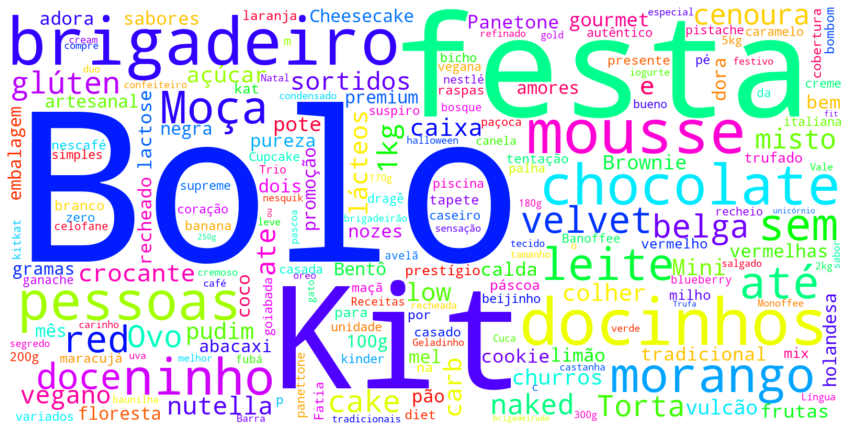

In [18]:
pedidos = df_products_merged.dropna(subset=['nome'],axis=0)['nome']
todas_palavras = " ".join(palavra for palavra in pedidos)

stopwords = set(STOPWORDS)
stopwords.update(['de','I','no','ao','gr','kg'])

wordcloud = WordCloud(stopwords=stopwords, background_color='white', width=1600, height=800, collocations=False,
                      colormap='hsv').generate(todas_palavras)

fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

wordcloud.to_file('wordcloud_vemdebolo.png');

<p>Porém, em função do perfil de consumo ocasional, foi possível observar que a maior parte das consumidoras cadastradas é não recorrente, sendo que a maioria nunca realizou uma compra na plataforma. Nesse sentido, é possível especular que está ocorrendo uma percepção de valor indevida por parte das consumidoras, restando para a Vem de Bolo apenas as compras de ocasiões especiais. Nesse sentido, as compras de doces do dia-a-dia e dos finais de semana podem estar sendo direcionadas para plataformas de maior abrangência e consideradas mais "acessíveis".</p>
<p>Como visto abaixo, 60% das consumidoras cadastradas ainda não transacionaram na plataforma e cerca de 40% compraram entre 1 e 10 vezes, sendo muito baixo o número de consumidoras consideradas <em>heavy users</em>.</p>

In [19]:
dados = pd.DataFrame(consumidoras_por_categoria.value_counts())
dados.reset_index(level=0, inplace=True)
dados = dados.set_axis(['range', 'qtd'], axis=1, inplace=False)

fig = px.pie(values=dados.qtd,
             title='Quantidade de compras dos usuários cadastrados',
             color_discrete_sequence=['rgb(51, 85, 171)', 'rgb(82, 97, 198)', 'rgb(157, 204, 237)'],
             names=[0, ('1 a 10'), ('11 a 43')])

fig.update_layout(uniformtext_minsize=17, uniformtext_mode='hide',
                  title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})

fig.show()

<p>Por sua vez, olhando apenas para as consumidoras ativas, validamos a percepção da dificuldade de retenção, sendo observada uma queda exponencial no consumo após a primeira compra, o que pode estar ocorrendo por diversos motivos, desde a percepção de valor dos produtos da plataforma até a própria concorrência enfrentada pela Vem de Bolo, uma vez que compete numa região com alta penetração de concorrentes de maior porte e estrutura operacional.</p>

In [20]:
df_customer_payments = pd.read_csv('tb_customer_payments.csv', sep = ";")

clientes = df_customer_payments.groupby('id_cliente').size().sort_values(ascending=True)
separados = pd.cut(clientes.values,bins=[0,1,2,4,9,clientes.max()],labels=['1','2','3-4','5-9','10+'],include_lowest=True)

fig = px.bar(separados.value_counts())

fig.update_layout(
        xaxis_tickfont_size=14,
        yaxis={'title':'Clientes'},
        xaxis={'title':'Compras'},
        title={'text': 'Número de clientes por quantidade de compras',
               'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5},
        showlegend=False)

fig.show()

<p>Ainda, buscamos determinar se a fidelização das consumidoras impactaria o <em>ticket</em> médio, porém não foi observada nenhuma correlação.</p>

In [21]:
df_usuarios_ativos = df_users[df_users.qtde_total_compra >= 1 ]

fig = px.scatter(data_frame=df_usuarios_ativos,
                 x="qtde_total_compra",
                 y="ticket_medio", 
                 title='Relação entre quantidade de compras e valor médio do gasto por compra.',
                 labels={'qtde_total_compra': 'Número de Compras', 'ticket_medio': 'Valor médio por compra'})

fig.update_layout(uniformtext_minsize=17, uniformtext_mode='hide',
                  title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})
fig.show()

<p>Passando para a análise dos dados de utilização de cupons e seu impacto na atração de novas consumidoras, observamos que quase metade das novas clientes da plataforma foram captadas por meio dessa estratégia, o que denota a sua importância como instrumento de <em>marketing</em> e atração de consumidoras.</p>

In [22]:
novos_clientes_cupons = df_coupons.novos_clientes_adquiridos.sum()

novos_clientes = pd.Series([novos_clientes_cupons, consumidoras_por_categoria.value_counts()[1]-novos_clientes_cupons],
                           index=['com cupons', 'sem cupons'])

fig = px.pie(values=novos_clientes,
             title='Novas Consumidoras na Plataforma',
             names=novos_clientes.index,
             color_discrete_sequence=['rgb(82, 97, 198)', 'rgb(157, 204, 237)'],)

fig.update_layout(uniformtext_minsize=17, uniformtext_mode='hide',
                  title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})
fig.show()

<p>Com relação ao <em>delivery</em> dos produtos, ficou constatado que o raio médio das entregas varia entre 8km e 20km. Acreditamos que essa característica facilita a expansão da plataforma para outras localidades e regiões do país sem alterações significativas em sua operacionalização.</p>

In [23]:
fig = px.box(data_frame=df_vendors,
             x='delivery_raio_km', 
             labels={'delivery_raio_km': 'Raio Delivery (km)'}, 
             title='Variação do Raio Máximo de Delivery')

fig.update_layout(uniformtext_minsize=17,
                  uniformtext_mode='hide',
                  title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})

fig.show()

<h2>Terceira Seção: Discussão de ideias e proposta de solução</h2>

<p>Uma vez compreendidos os dados fornecidos e a operação atual da Vem de Bolo, partimos para a busca de uma solução para o problema de expansão da plataforma, olhando de modo propositivo as alternativas estratégicas e como a tecnologia pode ajudar a resolver o desafio em questão. Nessa etapa, exploramos o mapeamento de regiões consideradas favoráveis para a localização de futuras operações da Vem de Bolo e, uma vez definida a região a ser adotada, propomos as cidades que deveriam ser alvo para a expansão da plataforma.</p>

In [24]:
df_cognatis = pd.read_csv('tb_solds_cognatis.csv', sep = ";")

#tratamentos iniciais
df_cognatis.MUNICIPIO = df_cognatis.MUNICIPIO.str.upper()
df_cognatis.dropna(how='any', inplace=True)
df_cognatis.MUNICIPIO = df_cognatis[['MUNICIPIO', 'UF']].agg('-'.join, axis=1)
df_cognatis.head()

SETOR_ATIV  UF       MUNICIPIO         CEP  TRABALHADORES  \
4833  AGROPECUARIA  CE      MIRAIMA-CE  62530000.0           23.0   
4834  AGROPECUARIA  CE  NOVA OLINDA-CE  63165000.0         1264.0   
4835  AGROPECUARIA  ES    CARIACICA-ES  29140001.0        15231.0   
4836  AGROPECUARIA  ES       GUACUI-ES  29560000.0            1.0   
4837  AGROPECUARIA  ES        VIANA-ES  29130001.0         2488.0   

      S_RENDA_MEDIA  S_FLUXO_PEDESTRE  S_FLUXO_VEICULOS  S_POP_TOTAL  \
4833     994.059998               0.0               0.0       5250.0   
4834     696.119995               0.0               0.0      10707.0   
4835    1571.329956               4.0               5.0      70499.0   
4836     919.390015               0.0               0.0        984.0   
4837    1549.709961               2.0               5.0      16463.0   

      S_DOM_PART_PERM  ...  S_DE_50_99_FUNC  S_DE_100_249_FUNC  \
4833           1694.0  ...              0.0                0.0   
4834           3543.0  ...              2.0                0.0   
4835          26791.0  ...             24.0               12.0   
4836            344.0  ...              0.0                0.0   
4837           5480.0  ...              8.0                3.0   

      S_DE_250_499_FUNC  S_DE_500_999_FUNC  S_MAIS1000_FUNC  S_SUPERMERCADO  \
4833                0.0                0.0              0.0             0.0   
4834                0.0                1.0              0.0             0.0   
4835                4.0                1.0              1.0            15.0   
4836                0.0                0.0              0.0             0.0   
4837                0.0                0.0              0.0             2.0   

      S_TT_PADARIA  S_ATACADO  S_HIPERMERCADO  S_MINIMERCADO  
4833           1.0        0.0             0.0           21.0  
4834           6.0        0.0             1.0           41.0  
4835          81.0       20.0             3.0           82.0  
4836           0.0        0.0             0.0            2.0  
4837           9.0        8.0             0.0           45.0  

[5 rows x 50 columns]

<p>Primeiramente, utilizamos os dados das macro-regiões mercadológicas (ou "entornos") extraídos do <em>business intelligence</em> (Cognatis) com o objetivo de traçar o perfil das consumidoras da plataforma. Para tanto, utilizamos o algoritmo de aprendizado não supervisionado KMeans, por meio do qual nos foi possível clusterizar os diferentes tipos de dados disponíveis em torno de seus centros, de modo a buscar a existência de relações entre os dados considerados relevantes. A quantidade de clusters a serem utilizados foi definida por meio do método do cotovelo (ou "<em>elbow method</em>"), que reduz a variância da amostra por meio da redução da soma dos quadrados dos erros.</p>
<p>Como a planilha Cognatis possui quantidade significativa de informações, entendemos que seriam relevantes apenas dados relacionados ao perfil demográfico das consumidoras, a classe social de acordo com a renda e a existência de estabelecimentos físicos nos entornos , tais como supermercado e padarias, que competem com os produtos fornecidos na plataforma.</p>

In [25]:
colunas_relevantes = ['S_PCT_SENIOR', 'S_PCT_ADULTOS', 'S_PCT_ADOLESCENTE', 'S_PCT_CRIANCAS', 'S_PCT_CLASSE_A',
                                'S_PCT_CLASSE_B', 'S_PCT_CLASSE_C', 'S_PCT_CLASSE_D', 'S_PCT_CLASSE_E', 'S_TT_PADARIA',
                                'S_SUPERMERCADO', 'S_HIPERMERCADO', 'S_ATACADO', 'S_RENDA_PER_CAPITA']

df_cognatis_informacoes_relevantes = df_cognatis[colunas_relevantes]

In [26]:
#estruturação do algoritmo (KMeans)
tabela_knn = df_cognatis_informacoes_relevantes
scaler = preprocessing.StandardScaler().fit(tabela_knn)
tabela_cluster = scaler.transform(tabela_knn)

kmeans = KMeans(n_clusters=4, init='random') 
pred_y = kmeans.fit_predict(tabela_cluster)

distance = kmeans.fit_transform(tabela_cluster)
labels = kmeans.labels_
unique, counts = np.unique(labels, return_counts=True)

<p>Como se observa nas imagens abaixo, a clusterização não permitiu fazer inferências que indicassem uma categorização efetiva na busca por padrões entre os municípios.</p>

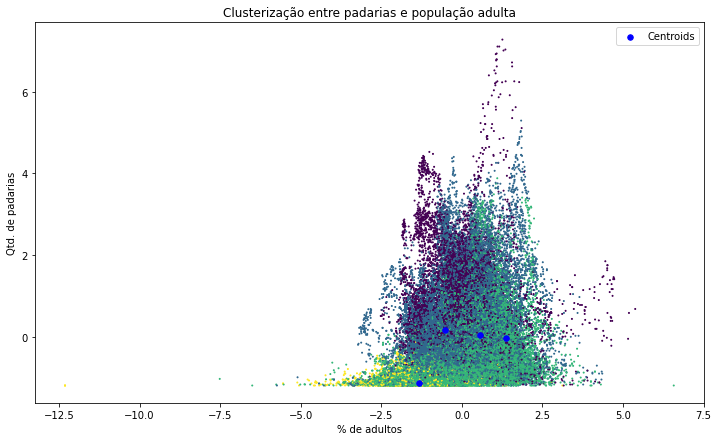

In [27]:
fig,ax = plt.subplots(figsize = (12,7))
ax.scatter(tabela_cluster[:, 1], tabela_cluster[:,9], s = 1, c = kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'blue',label = 'Centroids')

plt.title('Clusterização entre padarias e população adulta')
plt.xlabel('% de adultos')
plt.ylabel('Qtd. de padarias')
plt.legend()

plt.show()

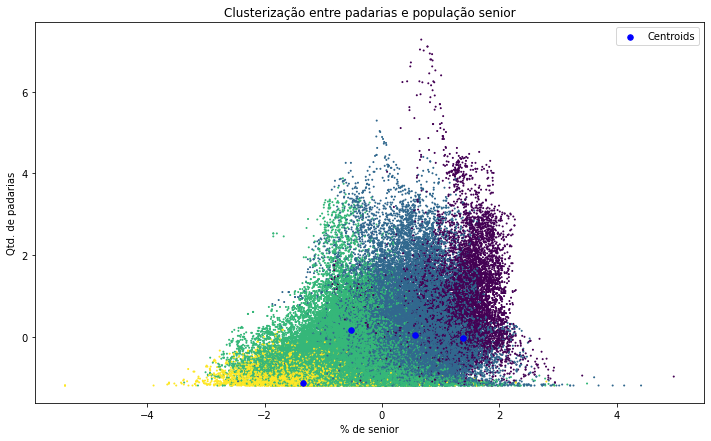

In [28]:
fig,ax = plt.subplots(figsize = (12,7))
ax.scatter(tabela_cluster[:, 0], tabela_cluster[:,9], s = 1, c = kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'blue',label = 'Centroids')

#plt.xlim(-2,1.1)
#plt.ylim(-2,2)
plt.title('Clusterização entre padarias e população senior')
plt.xlabel('% de senior')
plt.ylabel('Qtd. de padarias')
plt.legend()

plt.show()

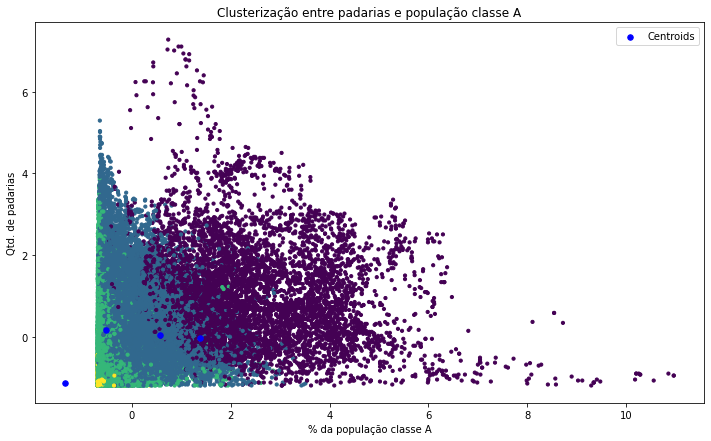

In [29]:
fig,ax = plt.subplots(figsize = (12,7))
ax.scatter(tabela_cluster[:,4], tabela_cluster[:,9], s = 10, c = kmeans.labels_)
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 30, c = 'blue',label = 'Centroids')

#plt.xlim(-2,1.1)
#plt.ylim(-2,2)
plt.title('Clusterização entre padarias e população classe A')
plt.xlabel('% da população classe A')
plt.ylabel('Qtd. de padarias')
plt.legend()

plt.show()

<p>Uma vez que não nos foi possível traçar o perfil das consumidoras da plataforma a partir dos dados quantitativos originados da tabela Cognatis, consideramos que os principais fatores demográficos constantes da tabela e relevantes para a nossa decisão seriam a faixa etária populacional e a classe econômica predominante nas macro-regiões analisadas. Para calibrar os perfis desejados, atribuímos diferentes pesos às diferentes classificações disponíveis. A respeito, cabe mencionar que por tratar-se de informações por 'entorno', há sobreposição de certas informações, como os dados populacionais que, se somados, irão divergir da realidade. Contudo, atribuímos pesos apenas para informações expressas em percentuais, possibilitando o trabalho de forma consolidada, sem que a sobreposição de informações tivesse impacto na nossa análise.</p>

In [30]:
idade_municipio = df_cognatis.groupby('MUNICIPIO')[['S_PCT_SENIOR','S_PCT_ADULTOS','S_PCT_ADOLESCENTE',
                                                    'S_PCT_CRIANCAS']].mean().round()
idade_municipio.S_PCT_SENIOR = idade_municipio.S_PCT_SENIOR * 2
idade_municipio.S_PCT_ADULTOS = idade_municipio.S_PCT_ADULTOS * 1.5
idade_municipio.S_PCT_ADOLESCENTE = idade_municipio.S_PCT_ADOLESCENTE * 1
idade_municipio.S_PCT_CRIANCAS = idade_municipio.S_PCT_CRIANCAS * 2


classe_municipio = df_cognatis.groupby('MUNICIPIO')[['S_PCT_CLASSE_A','S_PCT_CLASSE_B', 'S_PCT_CLASSE_C',
                                                     'S_PCT_CLASSE_D','S_PCT_CLASSE_E']].mean().round()
classe_municipio.S_PCT_CLASSE_A = classe_municipio.S_PCT_CLASSE_A * 2
classe_municipio.S_PCT_CLASSE_B = classe_municipio.S_PCT_CLASSE_B * 1.5
classe_municipio.S_PCT_CLASSE_C = classe_municipio.S_PCT_CLASSE_C * 1
classe_municipio.S_PCT_CLASSE_D = classe_municipio.S_PCT_CLASSE_D * 0.8
classe_municipio.S_PCT_CLASSE_E = classe_municipio.S_PCT_CLASSE_E * 0.5

df_filtro_demografico = pd.concat([idade_municipio, classe_municipio], axis=1, join='inner')
df_filtro_demografico['score'] = df_filtro_demografico.mean(axis=1)
df_filtro_demografico.head()

S_PCT_SENIOR  S_PCT_ADULTOS  S_PCT_ADOLESCENTE  \
MUNICIPIO                                                                
ABADIA DE GOIAS-GO              30.0           43.5               14.0   
ABADIA DOS DOURADOS-MG          38.0           45.0               13.0   
ABADIANIA-GO                    36.0           45.0               15.0   
ABAETE-MG                       38.0           43.5               14.0   
ABAETETUBA-PA                   22.0           48.0               16.0   

                        S_PCT_CRIANCAS  S_PCT_CLASSE_A  S_PCT_CLASSE_B  \
MUNICIPIO                                                                
ABADIA DE GOIAS-GO                38.0             0.0            25.5   
ABADIA DOS DOURADOS-MG            16.0             2.0            13.5   
ABADIANIA-GO                      26.0             0.0            18.0   
ABAETE-MG                         20.0             2.0            19.5   
ABAETETUBA-PA                     28.0             2.0            12.0   

                        S_PCT_CLASSE_C  S_PCT_CLASSE_D  S_PCT_CLASSE_E  \
MUNICIPIO                                                                
ABADIA DE GOIAS-GO                50.0            24.8             0.5   
ABADIA DOS DOURADOS-MG            49.0            30.4             2.0   
ABADIANIA-GO                      48.0            27.2             2.5   
ABAETE-MG                         46.0            30.4             1.0   
ABAETETUBA-PA                     35.0            32.0             8.0   

                            score  
MUNICIPIO                          
ABADIA DE GOIAS-GO      25.144444  
ABADIA DOS DOURADOS-MG  23.211111  
ABADIANIA-GO            24.188889  
ABAETE-MG               23.822222  
ABAETETUBA-PA           22.555556

<p>De modo a complementar as informações da tabela Cognatis, obtivemos a base de dados populacionais do IBGE com a população total de cada cidade.</p>

In [31]:
def padronizaString(string):
    return unicodedata.normalize("NFD", string).encode("ascii", "ignore").decode("utf-8").upper().strip()

estados = {'São Paulo': '-SP', 'Rio de Janeiro': '-RJ', 'Rio Grande do Sul': '-RS', 'Santa Catarina': '-SC',
           'Paraná': '-PR','Espírito Santo': '-ES', 'Minas Gerais': '-MG', 'Mato Grosso do Sul': '-MS',
           'Mato Grosso': '-MT', 'Goiás': '-GO', 'Distrito Federal': '-DF', 'Tocantins': '-TO', 'Rondônia':'-RO',
           'Amazonas': '-AM', 'Acre': '-AC', 'Roraima': '-RR', 'Pará': '-PA', 'Amapá': '-AP', 'Maranhão': '-MA',
           'Piauí': '-PI', 'Ceará': '-CE', 'Rio Grande do Norte': '-RN', 'Paraíba': '-PB', 'Pernambuco': '-PE',
           'Alagoas': '-AL', 'Sergipe':'-SE', 'Bahia':'-BA'}

df_populacao = pd.read_csv('dados_populacionais.csv', names=['municipio','estado','populacao'])

df_populacao.municipio = df_populacao.municipio.apply(padronizaString)
df_populacao.estado = df_populacao.estado.map(estados)
df_populacao.municipio = df_populacao[['municipio', 'estado']].agg(''.join, axis=1)
df_populacao.set_index('municipio', inplace=True)
df_populacao.drop('estado',axis=1, inplace=True)
df_populacao.populacao = df_populacao.populacao.str.replace(' ','').astype('float64')

df_populacao = df_populacao[~df_populacao.index.duplicated()]
df_populacao.head()

populacao
municipio                    
SAO PAULO-SP       12396372.0
RIO DE JANEIRO-RJ   6775561.0
BRASILIA-DF         3094325.0
SALVADOR-BA         2900319.0
FORTALEZA-CE        2703391.0

<p>Como foi visto na Segunda Seção, a plataforma vem enfrentando grandes dificuldades para atrair e fidelizar as suas consumidoras. A respeito, acreditamos que a atuação em São Paulo é prejudicada pela concorrência com as principais plataformas de <em>delivery</em>, de modo que optamos por priorizar cidades com mercado menos disputado.</p>
<p>Sendo assim, além da ponderação dos fatores demográficos já realizada, também filtramos e ordenamos as cidades considerando seu tamanho, limitando o intervalo alvo entre uma população de, no mínimo, 300.000 habitantes, que acreditamos ser um mínimo viável do ponto de vista operacional, até um milhão de habitantes, para que nosso universo de possibilidades não incluísse as principais metrópoles brasileiras, pelos motivos já assinalados.</p>

In [32]:
df_filtro_demografico = pd.concat([df_filtro_demografico, df_populacao], axis=1, join='inner')
df_filtro_demografico_populacao = df_filtro_demografico.query('300_000 < populacao < 1_000_000')
df_melhores_cidades = df_filtro_demografico_populacao.sort_values('score',ascending=False).head(15)

In [33]:
df_melhores_cidades.index

Index(['FLORIANOPOLIS-SC', 'BLUMENAU-SC', 'VITORIA-ES', 'RIBEIRAO PRETO-SP',
       'CAXIAS DO SUL-RS', 'JOINVILLE-SC', 'SAO JOSE DOS CAMPOS-SP',
       'NITEROI-RJ', 'JUNDIAI-SP', 'TAUBATE-SP', 'SAO BERNARDO DO CAMPO-SP',
       'SAO JOSE DOS PINHAIS-PR', 'MARINGA-PR', 'SAO JOSE DO RIO PRETO-SP',
       'PIRACICABA-SP'],
      dtype='object')

<p>Na tabela a seguir, é possível visualizar as quinze principais cidades definidas através do nosso modelo, com destaque para o <strong>Triângulo Catarinense</strong>, composto pelas cidades de Florianópolis, Blumenau e Joinville, que nos pareceu a melhor escolha para a expansão da marca Vem de Bolo com base no <em>ranking</em> do nosso modelo.</p>
<p>Como será visto adiante, as cidades escolhidas possuem relevante população de renda adequada ao perfil de consumo desejado, encontram-se em um eixo logístico e à distâncias favoráveis para a gestão da qualidade e curadoria da Vem de Bolo, além de possuírem ampla disponibilidade de acesso à internet, o que é fator fundamental para o sucesso da plataforma.</p>

In [34]:
cidades, estados = [], []
for i in df_melhores_cidades.index:
    a = i.split('-')[0].title()
    b = i.split('-')[1]
    cidades.append(a)
    estados.append(b)

cores = ['rgb(185,185,185)'] * 6
cores[0] = "rgb(82, 97, 198)"
fig = go.Figure(px.bar(df_melhores_cidades, x="score", y=cidades, color=estados, orientation='h',
             color_discrete_sequence=cores,
             title='Pontuação das cidades (população entre 300 mil e 1 milhão)',
             labels={
                     "y": "Cidades",
                     "score": "Pontuação",
                 }))

fig.update_layout(title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})

fig.show()

<p>No mapa a seguir, vemos a localização das cidades citadas, sendo possível observar que a região definida destaca-se como o principal <em>cluster</em>, depois somente da região metropolitana de São Paulo, onde encontra-se instalada a operação original da Vem de Bolo.

In [35]:
cidades, estados = [], []
for i in df_melhores_cidades.index:
    cidades.append(i[:-3])
    estados.append(i[-2:])

latitude, longitude = [], []
locator = Nominatim(user_agent="myGeocoder")
for i in zip(cidades, estados):
    location = locator.geocode(f"{i[0]}, {i[1]}, BRAZIL")
    latitude.append(location[1][0])
    longitude.append(location[1][1])

In [36]:
cidades_escolhidas = pd.DataFrame(cidades, estados).reset_index().rename(columns={'index': 'estados', 0: 'cidades'})
cidades_escolhidas['latitude'] = latitude
cidades_escolhidas['longitude'] = longitude

In [37]:
map1 = folium.Map(zoom_start=100)
cidades_escolhidas.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
map1

<p>O amplo acesso à internet é fundamental para a decisão de expandir a Vem de Bolo para o Triângulo Catarinense e, com base em dados de acesso disponíveis na Pesquisa Nacional de Amostras por Domicílio - PNAD, feita pelo IBGE em 2020 e divulgada em 2021, a região proposta é uma das com maior amplitude de acesso no território brasileiro, como demonstrado abaixo.</p>

In [38]:
df_internet = pd.read_excel('dados_acesso_internet_brasil_pnad.xlsx')

cores = ['rgb(185,185,185)'] * 5
cores[4] = "rgb(82, 97, 198)"

fig = go.Figure(px.bar(df_internet, x="Região", y='Acesso a Banda Larga Fixa', color_discrete_sequence=cores,
                       title='Acesso a internet por banda larga', color='Região'))

fig.update_yaxes(range=[0.5, 0.84])
fig.update_layout(title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})

fig.show()

<p>Também consultamos os dados do IBGE sobre a renda, sendo que as cidades escolhidas figuram entre as top 5 do Estado. </p>

In [39]:
df_pib = pd.read_excel('top_cinco_pib_sc_ibge_cidades.xlsx')
df_pib.PIB = df_pib.PIB * 1000

trace_pib = go.Bar(x=df_pib.Cidade, y=df_pib.PIB, marker_color='rgb(82, 97, 198)')

fig = go.Figure(data = [trace_pib],
layout=go.Layout(title=go.layout.Title(text='Top 5 de cidades de Santa Catarina (por renda)')))
fig.update_layout(title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.5})
fig.show()

<p>Por fim, reforçamos a importância da existência de consumidoras potenciais na região escolhida, o que pode acabar gerando maior impacto da iniciativas da Vem de Bolo no desenvolvimento de vendedoras que atendam a demanda desse público. Em especial no caso de vendas pela internet, com base em números de pesquisa realizada pelo Instituto de Qualidade iBest, observamos que há alta relação entre a renda e a utilização de plataformas, sendo que as classes A e B respondem por quase metade das vendas, embora representem apenas 15% da população, de acordo com dados de pesquisas independentes de renda.</p>

In [40]:
df_classes = pd.read_excel('classes_economicas.xlsx')

trace1 = go.Bar(x=df_classes.Classe,
                y=df_classes['Pct Pop.'],
                name='% População',
                marker_color='rgb(82, 97, 198)')
trace2 = go.Bar(x=df_classes.Classe,
                y=df_classes['Pct app delivery'],
                name='% utilização de apps',
                marker_color='rgb(157, 204, 237)')

fig = go.Figure(data = [trace1, trace2],
layout=go.Layout(title=go.layout.Title(text='Utilização de apps de delivery por classe social')))
fig.update_layout(title={'xanchor': 'center','yanchor': 'top','y':0.95,'x':0.45})
fig.show()

<h2>Conclusão</h2>

<p>Por todo o exposto, acreditamos que a Vem de Bolo esteja sendo vista como uma plataforma <em>premium</em> e de consumo em ocasiões especiais, de modo que as compras do dia-a-dia e de finais de semana aparentam estar sendo direcionadas para plataformas concorrentes. Isso se torna ainda mais claro quando consideramos a região de atuação na Grande São Paulo, onde o consumo por meio de aplicativos de entrega está mais consolidado e o apelo do relacionamento entre consumidoras e vendedoras é menos relevante. Portanto, acreditamos que a Vem de Bolo deveria buscar atingir regiões de menor porte, onde o apelo da plataforma pode ser mais eficaz.</p>
<p>Nesse sentido, desenvolvemos um modelo que nos permitiu mapear o Triângulo Catarinense (composto por Florianópolis, Blumenau e Joinville) como uma ótima opção de expansão, tendo em vista a proximidade geográfica entre as cidades, o amplo acesso à internet de banda larga e a existência de um público consumidor relevante.</p>
<p>Caso a proposta seja adotada, recomendamos também que os esforços de captação de novas clientes por meio de cupons seja mantido e reforçado, considerando inclusive o estabelecimento de parcerias locais para distribuição dos mesmos, tendo em vista sua significativa alavancagem junto à consumidora.</p>

<nav>
<p>Autores:</p>
<p>Marcos Florêncio, <a href="https://www.linkedin.com/in/marcos-florencio-ds/">LinkedIn</a>, <a href="https://github.com/themarcosf">Github</a></p>
<p>Luiz Rodrigues, <a href="https://www.linkedin.com/in/lhenriquear/">LinkedIn</a>, <a href="https://github.com/lhenriquear">Github</a></p>
<p>George Souza, <a href="https://www.linkedin.com/in/george-sousa/">LinkedIn</a>, <a href="https://github.com/Unitimu">Github</a></p>
<p>Diolan Godinho, <a href="https://www.linkedin.com/in/diolan-godinho-7282059b/">LinkedIn</a>, <a href="https://github.com/DiolanGodinho">Github</a></p>
</nav>